In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import utils
import torch 
from tqdm import tqdm

task='superdiagnostic'
modeltype='lenet'

signals,df,labels,model=utils.get_dataset_label_model(task=task, modeltype=modeltype)#, output_path='../../xai4ecg/output/logs/')
df['subdiagnostic'] = df['subdiagnostic'].apply(lambda x: eval(x))

/home/wagner/miniconda3/envs/xai4ecg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load model..
all parameters have same shape


100%|██████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 108.98it/s]


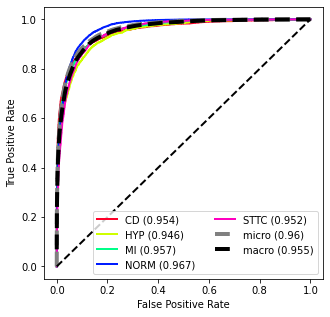

In [2]:
predictions = utils.predict_samples(model, signals)
aucs = utils.multiclass_roc_curve(labels, predictions, utils.label_mappings[task])

In [3]:
import attribute_signals as attr
from torch import nn

def get_median_beats(signals, df, t_before=30, t_after=50, only_beats=True):
    median_beats = []
    n = signals.shape[1]
    for i, signal in enumerate(signals):
        row = df.iloc[i]
        rpeaks = np.array(row.r_peaks).astype(int)
        beats = np.array([signal[ri-t_before:ri+t_after,:] for ri in rpeaks if (ri<n-t_after)&(ri > t_before)])
        median_beats.append(np.mean(beats,axis=0))  
    return np.array(median_beats)

mask = df.subdiagnostic.apply(lambda x: (('AMI' in x)|('IMI' in x))&(len(x)==1))

if modeltype == 'lenet':
    batch_size=64
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = model.sequential[:-2].forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)
else:
    feature_extractor = nn.Sequential(*list(model.model.children())[:-3])
    batch_size=32
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = feature_extractor.forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)
    
cidxs = predictions[mask].argmax(axis=-1)
method = 'gradient'
relevance = attr.attribute_signals(model, signals[mask], cidxs, labels.shape[-1], modeltype, method, batch_size=16)
heats = get_median_beats(relevance, df[mask])
beats = get_median_beats(signals[mask], df[mask])
unique_labels = df[mask].subdiagnostic.apply(lambda x: x[0])
beats.shape, heats.shape, features.shape

100%|█████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 16.54it/s]


((1952, 80, 12), (1952, 80, 12), (1952, 128))

input


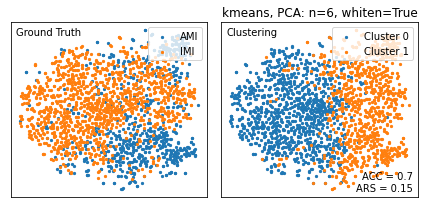

features


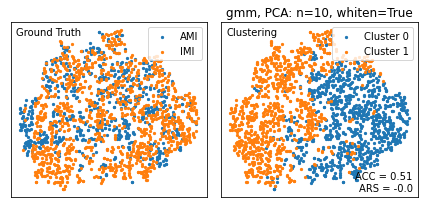

gradient_heats


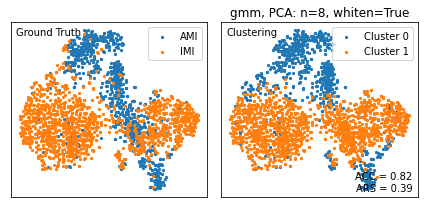

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import roc_auc_score, accuracy_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import copy

def do_clustering(representation, true_labels, cluster_model_type, n_clusters=2, whiten=True, n_init=1, do_pca=True, n_components=12):
    x = copy.copy(representation.reshape((len(representation), np.prod(representation.shape[1:]))))
    
    if do_pca:
        pca = PCA(n_components=n_components, whiten=whiten)
        x = pca.fit_transform(x)
    if cluster_model_type == 'kmeans':
        clustering_model = KMeans(n_clusters=n_clusters, n_init=n_init)
    elif cluster_model_type == 'gmm':
        clustering_model = GMM(n_components=n_clusters, n_init=n_init)#, covariance_type='full', tol=.0001, warm_start=True)
        
    clustering = clustering_model.fit_predict(x)
        
    ars = adjusted_rand_score(encoded_tmp_labels, clustering)
    acc = max([
        accuracy_score(true_labels, clustering),
        accuracy_score(true_labels, 1-clustering)])
    
    return clustering, ars, acc, clustering_model, pca#, real_c

if True:
    tsne_model_input = TSNE()
    embedding_input = tsne_model_input.fit_transform(beats.reshape((len(beats), np.prod(beats.shape[1:]))))

    tsne_model_feature = TSNE()
    embedding_feature = tsne_model_feature.fit_transform(features.reshape((len(features), np.prod(features.shape[1:]))))

    tsne_model_attr = TSNE()
    embedding_attr = tsne_model_attr.fit_transform(heats.reshape((len(heats), np.prod(heats.shape[1:]))))

hyperparameters = {
    'input':{
        'title':'Input',
        'x':beats,
        'z':embedding_input,
        'cluster_method':'kmeans',
        'do_pca':True,
        'n_components':6,
        'whiten':True,
        'n_init':10
    },
    'features':{
        'title':'Hidden Features',
        'x':features,
        'z':embedding_feature,
        'cluster_method':'gmm',
        'do_pca':True,
        'n_components':10,
        'whiten':True,
        'n_init':10
    },
    'gradient_heats':{
        'title':'Attribution',
        'x':heats,
        'z':embedding_attr,
        'cluster_method':'gmm',
        'do_pca':True,
        'n_components':8,
        'whiten':True,
        'n_init':10
    }
}

le = LabelEncoder()
encoded_tmp_labels = le.fit_transform(unique_labels)
pca_models = []
for i, (key, param_dic) in enumerate(hyperparameters.items()):
    print(key)
    if key in ['input', 'features', 'gradient_heats']:
        clustering, ars, acc, cluster_model, pca_model = do_clustering(
            param_dic['x'], 
            encoded_tmp_labels, 
            param_dic['cluster_method'], 
            n_components=param_dic['n_components'], 
            do_pca=param_dic['do_pca'], 
            whiten=param_dic['whiten'],
            n_init=param_dic['n_init'])
        pca_models.append(pca_model)
        fig, axarr = plt.subplots(1,2, figsize=(6,3))

        for labeli in np.unique(unique_labels):
            sel = param_dic['z'][unique_labels == labeli]
            axarr[0].scatter(sel[:,0], sel[:,1], label=labeli,s=5,alpha=1.)

        for labeli in np.unique(clustering):
            sel = param_dic['z'][clustering == labeli]
            axarr[1].scatter(sel[:,0], sel[:,1],s=5,alpha=1., label="Cluster " + str(labeli))

        axarr[1].text(.975,.025,'ACC = '+str(np.round(acc,2))+'\nARS = '+str(np.round(ars,2)), ha='right', va='bottom',transform=axarr[1].transAxes)
        axarr[0].text(.025,.975,'Ground Truth', ha='left', va='top',transform=axarr[0].transAxes)
        axarr[1].text(.025,.975,'Clustering', ha='left', va='top',transform=axarr[1].transAxes)

        axarr[0].legend(loc='upper right')
        axarr[1].legend(loc='upper right')
        
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        axarr[1].set_title(param_dic['cluster_method']+', PCA: n='+str(param_dic['n_components'])+', whiten='+str(param_dic['whiten']))
        plt.tight_layout()
        #plt.savefig('embedding_'+param_dic['title']+'.png', bbox_inches='tight', pad_inches=.1, dpi=200)
        #plt.savefig('embedding_'+param_dic['title']+'.pdf', bbox_inches='tight', pad_inches=.1)
        plt.show()